# Making  Voronoi Area Maps

In [636]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import shapely 
from shapely.geometry import Point
from scipy.spatial import Voronoi as Voronoi
import itertools
import scipy.spatial 
import anthro.viz 
import tqdm
colors = anthro.viz.plotting_style()

A common viz technique used in the Ron Milo-esque estimation papers is Voronoi area diagrams as an alternative to pie or bar charts. I (Griffin) think they are very nice for this type of thing, but their generation is very, very non trivial. There are some online tools that are used for this, but for my own education and speed of use, I'd rather set up my own implementation. As I will only really care about one or two levels for the treemap, I do not believe it will be an overly complicated space. In this notebook, I screw around with trying to implement this using a combination of the scipy tools and the Shapely module for interacting with polygons. 

In [166]:
# Set up a fake set of values for a diagram 
N = 6
values = np.array(np.random.uniform(1, 100, N))
weights = values / values.sum()


## Problem I: Clipping the Voronoi Diagram
I want to use the scipy spatial voronoi function as there is an easy way to compute the power diagram (on which I'll elaborate later). The problem is that some ridges are (rightly) drawn to infinity. I need to figure out hoow to bound them to a unit box. 

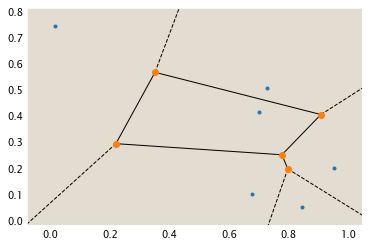

In [167]:
# Ransomly position them within a unit square
np.random.seed(666)
N = len(weights)
sites = np.stack([np.random.rand(N), np.random.rand(N)], axis=1)

# Compute the voronoi tesselation and plot 
vor = Voronoi(sites)
_ = scipy.spatial.voronoi_plot_2d(vor)

The dashed lines in the plot above represent polygon edges that extend to infinity. These are represented by values of [-1] when I examine the ridges of the vor object. There is a *really* clever hack of how to deal with this using the fact that voronoi tesselations are O(n log n) in time (https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells). The general scheme is to reflect all of these points  such that they are repeated surrounding the "unit cell" o [[0, 1], [0, 1]]. Then, draw the voronoi tesselations, and keep only those points/vertices within the original bounding box. The code provided on that SO post is really unnecessarily complicated, however, so I will try to hack the hack on my own. 

In [613]:
def mirror_points(sites, bounds):
    left_points = np.copy(sites)
    right_points = np.copy(sites)
    top_points = np.copy(sites)
    bottom_points = np.copy(sites)
    for i, s in enumerate(sites):
        left_points[i][0] = bounds[0] - (left_points[i][0] - bounds[0])
        right_points[i][0] = bounds[1] + (bounds[1] - right_points[i][0])
        top_points[i][1] = bounds[1] + (bounds[1] - top_points[i][1])
        bottom_points[i][1] = bounds[0] - (bottom_points[i][1] - bounds[0])
    new_sites = np.append(sites,
                          np.append(np.append(left_points, right_points, axis=0),
                                    np.append(bottom_points, top_points, axis=0),
                                           axis=0),
                                 axis=0)
    return new_sites

def voronoi_tesselation(sites, target):
    """
    Computes the Voronoi tesselation and retains only the first fifth of the points. 
    """
    vor = Voronoi(sites)
    vor.filtered_regions = np.array(vor.regions)[vor.point_region[:vor.npoints//5]]

    # return only teh vertices, points, and regions. 
    vertices = [vor.vertices[region, :-1] for region in vor.filtered_regions]
    points = [sites[i] for i in range(int(len(sites)/5))]
    ridges = [vor.vertices[region + [region[0]], :-1] for region in vor.filtered_regions]
    return dict(vertices=vertices, points=points, ridges=ridges, sites=sites[:int(len(sites) / 5)],
                target_area=target, original_vor=vor)


In [190]:
sites3d = np.stack([np.random.rand(N), np.random.rand(N), np.random.rand(N)], axis=1)
sites3d

array([[0.01645358, 0.10377152, 0.96267468],
       [0.23499383, 0.44644312, 0.19705023],
       [0.51117131, 0.96918917, 0.71458996],
       [0.29200924, 0.73847112, 0.16192394],
       [0.50189351, 0.71955061, 0.86625477],
       [0.49827313, 0.89304339, 0.62382025]])

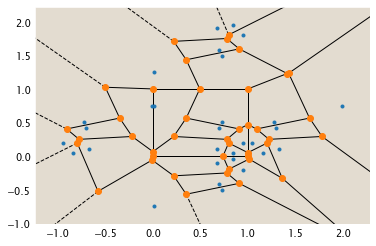

In [173]:
new_vor = Voronoi(mirror_points(sites, [0, 1]))
_ = scipy.spatial.voronoi_plot_2d(new_vor)

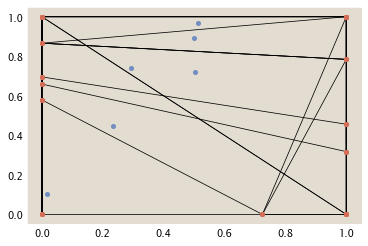

In [227]:
clipped = voronoi_tesselation(mirror_points(sites3d, [0, 1]), target=weights)

fig, ax = plt.subplots(1, 1)

for p in clipped['points']:
    ax.plot(p[0], p[1], '.', color=colors['blue'], ms=8)
for r in clipped['ridges']:
    ax.plot(r[:, 0], r[:, 1], 'k-', lw=0.75)
for v in clipped['vertices']:
    ax.plot(v[:, 0], v[:, 1], '.', color=colors['red'], ms=8)
    

Great! Those few functions seem to really give me what I need. 

## Problem III: Convert to Shapely Objects To Compute Centroid and Area of Voronoi Regions
In building the actual area diagram, I will need to be able to convert these bounded voronoi regions. This will be important because I need to be able to simply compute the centroid and area, and update the positions of the centroids based on some weighting value, a point I will get to later. 

The python module Shapely seems to be the standard in the field for computing these types of things. I will see if I can convert these vertices and ridges to discrete polygons.

In [175]:
lines = shapely.geometry.MultiLineString(clipped['ridges']).buffer(1E-5)
poly = shapely.ops.polygonize(lines)
centroids = []
for p in poly:
    print(p.area)
    centroids.append([p.centroid.x, p.centroid.y])

0.00014084503270073157
0.18944012092553245
0.03094598321389193
0.05330813790967408
0.1329695490899893
0.3075432949936856
0.28569206914818074


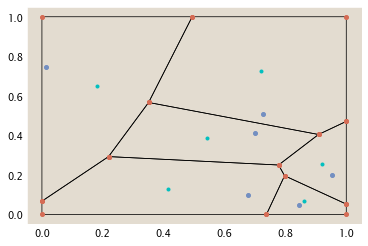

In [176]:
fig, ax = plt.subplots(1, 1)

for p in clipped['points']:
    ax.plot(p[0], p[1], '.', color=colors['blue'], ms=8)
for r in clipped['ridges']:
    ax.plot(r[:, 0], r[:, 1], 'k-', lw=0.75)
for v in clipped['vertices']:
    ax.plot(v[:, 0], v[:, 1], '.', color=colors['red'], ms=8)
for c in centroids[1:]:
    ax.plot(c[0], c[1], '.', color='c')

Great. This seems to get the centroids. I can also use this to get the areas pretty reliably. Note that I will *always* need to neglect

In [177]:
def compute_props(clipped, keyval='ridges', eps=1E-5):
    """
    Given a clipped voronoi diagram, compute the centroid and area of each voronoi cell.
    """
    # Generate the polygons
    lines = shapely.geometry.MultiLineString(clipped[keyval]).buffer(eps)
    poly = shapely.ops.polygonize(lines)[1:]

    # Set up storage lists for centroids and areas
    centroidsx = []
    centroidsy = []
    areas = []
    distance = []
    adapt = []
    # Iterate through the valid polygons, compute, and return a dict. 
    for i, p in enumerate(poly):
        centroidsx.append(p.centroid.x)
        centroidsy.append(p.centroid.y)
        distance.append(np.abs(p.exterior.distance(p.centroid)))
        areas.append(p.area)
        adapt.append(p.area / clipped['target'][i])
    return dict(centroids_x=np.array(centroidx), centroids_y=np.array(centroidsy),
                 centroids=np.stack([np.arrray(centroidsx), np.array(centroidsy)], axis=0),
                 areas=areas, polygons=poly)

## Problem III: Computing the Power Diagram

The crux of building an acccurate voronoi area map is that you have to compute the power diagram. This is related to the Delaunay triangulation of the voronoi diagram and is critical for assigning weights to different cells. There are formal ways to compute this, BUT a very key (and convenient, in our case) abstraction of this is that power diagram in dimension $N$ is the same as a Voronoi diagram in dimension $N+1$ (https://stackoverflow.com/questions/16024428/reference-algorithm-for-weighted-voronoi-diagrams). This means that for the seed positions of the cells, I just have to include a 3rd dimension (a weight of whatever flavor I would like) and compute the voronoi diagram on that. The best part is that to get the power diagram, I just have to neglect this third dimension (just like marginalization in MCMC)! I have built the functions thus far to accomodate that.



updating this point -- this is not so simple. Projection is non trivial. 


## Laguerre-Voronoi Implementation in Python.

Following https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627 with retyping



In [605]:
def compute_power_diagram(sites, weights):

    # Given an array of sites, lift them from 2D into 3D
    normalized_sites = np.sum(sites**2, axis=1) - weights**2
    lifted_sites = np.concatenate([sites, normalized_sites[:, None]], axis=1)
    # Compute the convex hull. 
    hull = scipy.spatial.ConvexHull(lifted_sites)
    # Define useful funcitons
    def norm2(X):
	    return np.sqrt(np.sum(X ** 2))
    def normalized(X):
	    return X / norm2(X)
    def _is_ccw(A, B, C):
        M = np.concatenate([np.stack([A, B, C]), np.ones((3, 1))], axis = 1)
        return np.linalg.det(M) > 0
    def _get_triangle_normal(A, B, C):
        return normalized(np.cross(A, B) + np.cross(B, C) + np.cross(C, A))
    def _get_power_circumcenter(A, B, C):
        N = _get_triangle_normal(A, B, C)
        return (-.5 / N[2]) * N[:2]

    # Special case for 3 points
    if sites.shape[0] == 3:
        if _is_ccw(sites[0], sites[1], sites[2]):
            tri_list, voronoi_vertices = [[0, 1, 2]], np.array([_get_power_circumcenter(*lifted_sites)])
        else:
            tri_list, voronoi_vertices = [[0, 2, 1]], np.array([_get_power_circumcenter(*lifted_sites)])
    else:
        tri_list = tuple([a, b, c] if _is_ccw(sites[a], sites[b], sites[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
        voronoi_vertices = np.array([_get_power_circumcenter(*lifted_sites[tri]) for tri in tri_list])

    # Get the voronoi cells
    vertices_set = frozenset(itertools.chain(*tri_list))

    # Keep track of which edge separate which triangles
    edge_map = { }
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]

    # For each triangle
    voronoi_cell_map = { i : [] for i in vertices_set }

    for i, (a, b, c) in enumerate(tri_list):
		# For each edge of the triangle
        for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
            # Finite Voronoi edge
            edge = tuple(sorted((u, v)))
            if len(edge_map[edge]) == 2:
                j, k = edge_map[edge]
                if k == i:
                    j, k = k, j
				
                # Compute the segment parameters
                U = voronoi_vertices[k] - voronoi_vertices[j]
                U_norm = norm2(U)				

                # Add the segment
                voronoi_cell_map[u].append(((j, k), (voronoi_vertices[j], U / U_norm, 0, U_norm)))
            else: 
                # Infinite Voronoi edge
                # Compute the segment parameters
                A, B, C, D = sites[u], sites[v], sites[w], sites[i]
                U = normalized(B - A)
                I = A + np.dot(D - A, U) * U
                W = normalized(I - D)
                if np.dot(W, I - C) < 0:
                    W = -W	
			
                # Add the segment
                voronoi_cell_map[u].append(((edge_map[edge][0], -1), (D,  W, 0, None)))				
                voronoi_cell_map[v].append(((-1, edge_map[edge][0]), (D, -W, None, 0)))				

        # Order the segments
    def order_segment_list(segment_list):
		# Pick the first element
        first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

        # In-place ordering
        segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
        for i in range(len(segment_list) - 1):
            for j in range(i + 1, len(segment_list)):
                if segment_list[i][0][1] == segment_list[j][0][0]:
                    segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
                    break

        # Job done
        return segment_list

    ordered = { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }

    # get the lines associated with all the Voronoi cells
    edge_map = { }
    for segment_list in ordered.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                valid = True
                for _i in range(2):
                    if U[_i].astype(str) == 'nan':
                        U[_i] = 0 
                if valid:
                    if (tmax is None) | (tmax is np.inf) | (tmax is np.nan):
                        tmax = 1.5
                    if (tmin is None) | (tmin is np.inf) | (tmin is np.nan):
                        tmin = -0.5          
                    edge_map[edge] = (A + tmin * U, A + tmax * U)
    return edge_map



In [615]:
np.random.seed(666)
N=10
sitesx = np.random.uniform(0.01, 1, N)
sitesy = np.random.uniform(0.01, 1, N)
sites = np.stack([sitesx, sitesy], axis=1)
mirror = mirror_points(sites, bounds=[0, 1])
weights = np.random.uniform(0, 1, N)
segs = compute_power_diagram(sites, weights)


In [618]:

segs.values()

dict_values([(array([0.95194338, 0.30029582]), array([0.95194338, 0.30029582])), (array([1.08183924, 0.30596394]), array([0.84574478, 0.74671263])), (array([ 0.30508554, -0.08314585]), array([0.28556214, 0.0080614 ])), (array([0.28556214, 0.0080614 ]), array([0.69594132, 0.80856909])), (array([0.28556214, 0.0080614 ]), array([-2.63907169, -0.37640331])), (array([0.67974919, 0.20096308]), array([-0.81802177,  0.11921864])), (array([0.58893734, 0.22431831]), array([0.73057948, 0.7038363 ])), (array([-2.99209604, -9.85396886]), array([ 0.30508554, -0.08314585])), (array([-2.63907169, -0.37640331]), array([-2.99209604, -9.85396886]))])

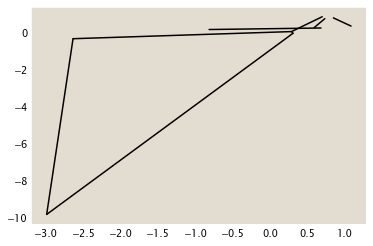

In [633]:
fig, ax = plt.subplots(1,1)
for v in segs.values():
    xs = [v[0][0], v[1][0]]
    ys = [v[0][1], v[1][1]]
    ax.plot(xs, ys, 'k-')




### Problem IV: Implementing the Nocaj & Brande Algorithm. 
Now, I just need to implement the algorithm defined by Nocaj and Brande in 2012 for computing a single layer. This should be relatively easy to do. 

In [334]:
def mirror_points(sites, bounds):
    left_points = np.copy(sites)
    right_points = np.copy(sites)
    top_points = np.copy(sites)
    bottom_points = np.copy(sites)
    points = []
    for s in sites:
        points.append(list(s))
    for i, s in enumerate(sites):
        left_points[i][0] = bounds[0] - (left_points[i][0] - bounds[0])
        right_points[i][0] = bounds[1] + (bounds[1] - right_points[i][0])
        top_points[i][1] = bounds[1] + (bounds[1] - top_points[i][1])
        bottom_points[i][1] = bounds[0] - (bottom_points[i][1] - bounds[0])
        points.append(list(left_points[i]))
        points.append(list(right_points[i]))
        points.append(list(top_points[i]))
        points.append(list(bottom_points[i]))
    new_sites = np.array(points)
    # new_sites = np.array(new_sites)
    # print(new_sites)
    return new_sites

def voronoi_tesselation(sites, target):
    """
    Computes the Voronoi tesselation and retains only the first fifth of the points. 
    """
    vor = Voronoi(sites, qhull_options='Qc')
    vor.filtered_regions = np.array(vor.regions)[vor.point_region[:vor.npoints//5]]

    # return only teh vertices, points, and regions. 
    points = []
    _vertices = [vor.vertices[region, :] for region in vor.filtered_regions]
    points = [sites[i] for i in range(int(len(sites)/5))]
    _ridges = [vor.vertices[region + [region[0]], :] for region in vor.filtered_regions]

    # Restrict
    vertices = []
    ridges = []
    for i, v in enumerate(_vertices):
        _verts_valid = []
        _ridges_valid = []
        for j, _v in enumerate(v):
            if (_v[-1] <= 0.5).all() & (_v[-1] >= -0.5).all():
                _verts_valid.append(_v)
                _ridges_valid.append(_ridges[i][j])
        vertices.append(np.array(_verts_valid))
        ridges.append(np.array(_ridges_valid))
   
    return dict(vertices=vertices, points=points, ridges=ridges, sites=sites[:int(len(sites) / 5)],
                target_area=target, original_vor=vor)

def compute_power_diagram(sites, targets, bounds=[0, 1]):
    mirror = mirror_points(sites, bounds)
    tesselation = voronoi_tesselation(mirror, targets)
    # props = compute_props(tesselation)
    return tesselation #[tesselation, props]

def adapt_position_weights(weights, props):
    new_weights = []
    for i, w in enumerate(weights):
        min_val = np.min([np.sqrt(w), props['distance'][i]]) 
        new_weights.append(min_val**2)
    sites = np.stack([props['centroids_x'], props['centroids_y'], new_weights], axis=1)
    return [sites, new_weights]

def adapt_weights(props, weights, err=1E-3):
    sites = props['centroids']
    new_weights = []
    for i, s in enumerate(sites):
        # Define a list of all *other* sites in the set
        other_sites = [tuple(s) for s_ in sites if tuple(s_) != tuple(s)]

        # Find the nearest neighbor
        nearest_neighbor = shapely.ops.nearest_points(shapely.geometry.Point(s), 
                                        shapely.geometry.MultiPoint(other_sites))
        w_new = np.sqrt(weights[i]) * props['adapt'][i]
        w_max = np.abs(shapely.geometry.LineString(nearest_neighbor).length)
        w_update = np.min([w_new, w_max])**2
        w_update = np.max(w_update, err)
        new_weights.append(w_update)
    updated_sites = np.stack([props['centroids_x'], props['centroids_y'], new_weights], axis=0)
    return [updated_sites, new_weights]

def optimize_voronoi(targets, const=100, bounds=[0, 1], iter_max=100, err=1E-3):
    # Initialize sites. 
    N = len(targets)
    sites_x = np.random.uniform(0, 1, N)
    sites_y = np.random.uniform(0, 1, N)
    W = np.random.uniform(0.1, 1, N)
    sites = np.stack([sites_x, sites_y, W], axis=1)

    # Given sites, compute the power diagram 
    # Given sites, morror points
    Vs, props = compute_power_diagram(sites, targets, bounds)
    for i in tqdm.tqdm(range(iter_max)):
        # Update positions
        S, W = adapt_position_weights(W, props)

        # Compute the power diagram
        Vs, props = compute_power_diagram(S, targets, bounds)

        # Adapt the weights
        S, W = adapt_weights(props, W, err)
        
        # Recompute the power diagram
        Vs, props = compute_power_diagram(S, targets, bounds)

        # Compute the error function 
        error = np.sum(props['areas'] - targets) / 2

        if error < err:
            break
    return [Vs, props]


In [335]:
np.random.seed(666)
sites3d = np.stack([np.random.uniform(0, 1, N), np.random.uniform(0, 1, N), np.random.uniform(0, 1, N)], axis=1)
t = compute_power_diagram(sites3d, weights, [0, 1])

In [336]:
t['ridges']

[array([[ 0.52967327,  1.        ,  0.404795  ],
        [ 1.        ,  0.37324102,  0.48443654],
        [ 1.        ,  1.        ,  0.38261984],
        [ 1.        ,  1.        , -0.4557432 ],
        [ 0.18262365,  0.0628589 , -0.48369385],
        [ 0.8310688 ,  0.32799533,  0.49975152],
        [ 1.        ,  0.27349064,  0.36964295],
        [ 1.        ,  0.29141459,  0.42567472]]),
 array([[1.00000000e+00, 3.73241016e-01, 4.84436538e-01],
        [8.31068800e-01, 3.27995327e-01, 4.99751520e-01],
        [1.00000000e+00, 1.38777878e-17, 3.89130874e-01],
        [1.00000000e+00, 2.91414591e-01, 4.25674721e-01]]),
 array([[ 1.82623651e-01,  6.28589041e-02, -4.83693855e-01],
        [ 8.31068800e-01,  3.27995327e-01,  4.99751520e-01],
        [ 1.00000000e+00, -4.16333634e-17,  2.74417447e-01],
        [ 1.00000000e+00,  1.38777878e-17,  3.89130874e-01],
        [ 1.00000000e+00,  2.73490644e-01,  3.69642949e-01],
        [ 1.00000000e+00,  2.91414591e-01,  4.25674721e-01],
      

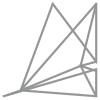

In [337]:
    lines = shapely.geometry.MultiLineString(t['ridges']).buffer(1E-3)
    lines

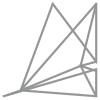

In [338]:
lines

In [277]:
v.ridge

AttributeError: 'Voronoi' object has no attribute 'ridges'

In [219]:
sites3d

array([[0.01645358, 0.10377152, 0.96267468],
       [0.23499383, 0.44644312, 0.19705023],
       [0.51117131, 0.96918917, 0.71458996],
       [0.29200924, 0.73847112, 0.16192394],
       [0.50189351, 0.71955061, 0.86625477],
       [0.49827313, 0.89304339, 0.62382025]])

In [233]:
t['vertices']

[array([[-1.11022302e-16,  1.00000000e+00],
        [ 1.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 7.24389328e-01,  6.93889390e-17],
        [ 0.00000000e+00,  5.79281667e-01],
        [ 0.00000000e+00,  5.55111512e-17],
        [-1.11022302e-16,  1.00000000e+00]]),
 array([[ 7.24389328e-01,  6.93889390e-17],
        [ 1.00000000e+00, -2.22044605e-16],
        [ 1.00000000e+00,  1.66533454e-16],
        [ 1.00000000e+00,  4.56309711e-01],
        [ 1.00000000e+00,  3.17806002e-01],
        [-1.11022302e-16,  6.59432645e-01],
        [-5.55111512e-17,  6.95629848e-01],
        [ 5.55111512e-17, -1.11022302e-16],
        [ 0.00000000e+00,  5.79281667e-01],
        [ 0.00000000e+00,  5.55111512e-17]]),
 array([[ 0.00000000e+00,  8.66205757e-01],
        [ 1.00000000e+00,  7.84402590e-01],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00],
        [-1.11022302e-16,  1

In [234]:
t['vor']

KeyError: 'vor'

In [236]:
v = t['original_vor']

In [237]:
v

In [238]:
v.vertices

array([[ 7.07131668e+00,  1.22701272e+01, -2.15732894e+00],
       [ 1.49971317e+00, -7.43524470e-01,  6.85187873e-01],
       [-5.79523401e-01, -9.98071024e-01,  7.67106425e-01],
       [-3.74460415e-01, -8.96837804e-01,  8.22890923e-01],
       [ 1.32176218e+00, -3.94329329e-01,  4.37951693e-01],
       [ 3.03643953e+00, -2.46743764e+00, -9.79350661e-01],
       [ 3.99010674e+00, -3.75720765e+00, -2.19683951e+00],
       [ 1.11029826e+00,  1.57008688e+00,  2.02633990e-01],
       [-4.51938834e-02,  1.29355435e+00,  6.26088431e-01],
       [-1.91464023e-01,  1.29074442e+00,  4.12030070e-01],
       [-2.89756989e-02,  1.13498756e+00,  5.65782140e-01],
       [-6.40068554e-02,  1.36953315e+00,  6.84754416e-01],
       [-4.64444837e-02,  1.32470068e+00,  6.59453519e-01],
       [ 1.41215486e+00,  2.54999425e+00,  5.77770202e-01],
       [ 1.11726383e+00,  1.72225445e+00,  3.57575016e-01],
       [-1.20766375e-01,  1.21612405e+00,  1.37872703e+00],
       [-1.09651919e+03, -6.71802004e+02

In [239]:
v.points

array([[ 0.01645358,  0.10377152,  0.96267468],
       [ 0.23499383,  0.44644312,  0.19705023],
       [ 0.51117131,  0.96918917,  0.71458996],
       [ 0.29200924,  0.73847112,  0.16192394],
       [ 0.50189351,  0.71955061,  0.86625477],
       [ 0.49827313,  0.89304339,  0.62382025],
       [-0.01645358,  0.10377152,  0.96267468],
       [ 1.98354642,  0.10377152,  0.96267468],
       [ 0.01645358,  1.89622848,  0.96267468],
       [ 0.01645358, -0.10377152,  0.96267468],
       [-0.23499383,  0.44644312,  0.19705023],
       [ 1.76500617,  0.44644312,  0.19705023],
       [ 0.23499383,  1.55355688,  0.19705023],
       [ 0.23499383, -0.44644312,  0.19705023],
       [-0.51117131,  0.96918917,  0.71458996],
       [ 1.48882869,  0.96918917,  0.71458996],
       [ 0.51117131,  1.03081083,  0.71458996],
       [ 0.51117131, -0.96918917,  0.71458996],
       [-0.29200924,  0.73847112,  0.16192394],
       [ 1.70799076,  0.73847112,  0.16192394],
       [ 0.29200924,  1.26152888,  0.161

# A different approach

I'm having a hard time getting this stupid power diagram calculated. Since i'm not doing anything insanely complex, we can look at using a stupider, more iterative approach

In [876]:
def mirror_points(sites, bounds):
    left_points = np.copy(sites)
    right_points = np.copy(sites)
    top_points = np.copy(sites)
    bottom_points = np.copy(sites)
    points = []
    for s in sites:
        points.append(list(s))
    for i, s in enumerate(sites):
        left_points[i][0] = bounds[0] - (left_points[i][0] - bounds[0])
        right_points[i][0] = bounds[1] + (bounds[1] - right_points[i][0])
        top_points[i][1] = bounds[1] + (bounds[1] - top_points[i][1])
        bottom_points[i][1] = bounds[0] - (bottom_points[i][1] - bounds[0])
        points.append(list(left_points[i]))
        points.append(list(right_points[i]))
        points.append(list(top_points[i]))
        points.append(list(bottom_points[i]))
    new_sites = np.array(points)

    return new_sites

def voronoi_tessellation(sites, target):
    """
    Computes the Voronoi tesselation and retains only the first fifth of the points. 
    """
    vor = Voronoi(sites)
    vor.filtered_regions = np.array(vor.regions)[vor.point_region[:vor.npoints//5]]

    # return only teh vertices, points, and regions. 
    points = []
    vertices = [vor.vertices[region, :] for region in vor.filtered_regions]
    points = [sites[i] for i in range(int(len(sites)/5))]
    ridges = [vor.vertices[region + [region[0]], :] for region in vor.filtered_regions]
   
    return dict(vertices=vertices, points=points, ridges=ridges, sites=sites[:int(len(sites) / 5)],
                target=target, original_vor=vor)

def compute_props(clipped, keyval='ridges', eps=1E-3):
    """
    Given a clipped voronoi diagram, compute the centroid and area of each voronoi cell.
    """
    # Generate the polygons
    lines = shapely.geometry.MultiLineString(clipped[keyval]).buffer(eps)
    poly = shapely.ops.polygonize(lines)

    # Set up storage lists for centroids and areas
    centroidsx = []
    centroidsy = []
    areas = []
    # Iterate through the valid polygons, compute, and return a dict. 
    for i, p in enumerate(poly):
        if i > 0:
            centroidsx.append(p.centroid.x)
            centroidsy.append(p.centroid.y)
            areas.append(p.area)

    return dict(centroids_x=np.array(centroidsx), centroids_y=np.array(centroidsy),
                 centroids=np.stack([np.array(centroidsx), np.array(centroidsy)], axis=1),
                 areas=areas, polygons=poly)


In [877]:
N = len(weights)
sites = np.stack([np.random.uniform(0, 1, N), np.random.uniform(0, 1, N)])



In [907]:
def adjust_weight(weights, areas, targets):
    new_weights = weights * (1 + ((areas - targets)/targets))
    new_weights[new_weights < 1] = 1
    return new_weights
    
def move_generators(sites, weights):
    new_sitesx = []
    new_sitesy = []
    for i, s1 in enumerate(sites):
        cx = 0
        cy = 0
        for j, s2 in enumerate(sites):
            if i != j:
               cx += np.abs(s1[0] - s2[0])**2 - (weights[i])
               cy += np.abs(s1[1] - s2[1])**2 - (weights[i])
        new_sitesx.append(cx/(len(weights) -1 ))
        new_sitesy.append(cy/(len(weights) -1 ))
    new_sites = np.stack([new_sitesx, new_sitesy], axis=1)
    return new_sites

def treemap_subdivision(targets, imax=100, tolerance=0.001, bounds=[0, 1]):
    # Initialize positions and weights within a unit square. 
    N = len(targets)
    S = np.stack([np.random.uniform(bounds[0], bounds[1], N), np.random.uniform(bounds[0], bounds[1], N)], axis=1)
    W = np.ones(N)

    stable = True
    # Compute the initial tesselation
    for _ in tqdm.tqdm(range(imax)):
        mirrors = mirror_points(S, bounds)
        Vs = voronoi_tessellation(mirrors, targets)
        props = compute_props(Vs)
        if (np.abs(props['areas'] - targets) >= tolerance).any():
            stable = False
        W = adjust_weight(weights, props['areas'], targets)

        # Move the generators
        S = move_generators(S, W)
        if stable:
            break
    return Vs


In [908]:

values = np.array([10, 80, 2, 3, 3, 40, 10, 100, 2, 40, 10, 5])
weights = values / values.sum()
v = treemap_subdivision(weights, imax=10)

10%|█         | 1/10 [00:00<00:02,  3.46it/s]


ValueError: operands could not be broadcast together with shapes (16,) (12,) 

In [909]:
fig, ax = plt.subplots(1, 1)

for p in v['points']:
    ax.plot(p[0], p[1], '.', color=colors['blue'], ms=8)
for r in v['ridges']:
    ax.plot(r[:, 0], r[:, 1], 'k-', lw=0.75)
for v in v['vertices']:
    ax.plot(v[:, 0], v[:, 1], '.', color=colors['red'], ms=8)
for c in v[1:]:
    ax.plot(c[0], c[1], '.', color='c')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [910]:
weights

array([0.03278689, 0.26229508, 0.00655738, 0.00983607, 0.00983607,
       0.13114754, 0.03278689, 0.32786885, 0.00655738, 0.13114754,
       0.03278689, 0.01639344])

In [916]:
N = len(weights)
S = np.stack([np.random.uniform(0, 1, N), np.random.uniform(0, 1, N)], axis=1)
W = np.ones(N) * 0.01
stable = True
# Compute the initial tesselation
mirrors = mirror_points(S, [0, 1])
Vs = voronoi_tessellation(mirrors, weights)
props = compute_props(Vs)
print(len(weights), len(props['areas']))
S = move_generators(S, W)
S

12 12


array([[0.05989865, 0.1460514 ],
       [0.46475831, 0.20964036],
       [0.09724866, 0.05888858],
       [0.06751374, 0.06425984],
       [0.12578101, 0.13578854],
       [0.08768005, 0.05887889],
       [0.14130569, 0.08202071],
       [0.08984364, 0.17072152],
       [0.08533315, 0.10120276],
       [0.18310195, 0.24659958],
       [0.07881621, 0.06006397],
       [0.05940197, 0.19851334]])

In [912]:
lines = shapely.geometry.MultiLineString(Vs['ridges'])
# poly = shapely.ops.polygonize(lines)
poly = shapely.ops.polygonize(lines)

In [875]:
for p in poly:
    print(p.area)

16.10570103790767
7.966296365880382
16.970639115659417
5.890910843199007
4.422243526640777
8.478351870362578
7.344839520767585
9.93940453416927
9.228713519271302


In [842]:
props['areas']

[0.18461466101302904,
 16.08815870923577,
 16.953116373071502,
 9.216377894936937,
 9.925378174084987,
 8.467042168036286,
 3.9139980326420885,
 3.0572668018160303,
 7.3333634351371755,
 6.6519397532845135,
 5.880387612867079,
 7.954843163268282,
 4.41351635715477]